In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import trange
import copy
import pickle, random
import librosa 

from IPython.display import Audio
import soundfile as sf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)

True
11.7
1.13.1


### MNIST data

In [3]:
mnist_train=torchvision.datasets.MNIST('mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]))

mnist_test=torchvision.datasets.MNIST('mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]))

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, shuffle=True, num_workers=16)
valloader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle= True, num_workers=16)

In [ ]:
def validate_model(model, criterion, valloader):
    with torch.no_grad():
        correct, total, running_validation_loss = 0, 0, 0
        for i, (images, labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += len(labels)
            correct += (predicted == labels).sum()
        
        validation_accuracy = 100 * correct / total
        total_validation_loss = (running_validation_loss) / len(valloader)
        return validation_accuracy.cpu().numpy(), total_validation_loss

In [4]:
# common function to train and validate
def train_model(model, criterion, optimizer, trainloader, valloader = None, epochs = 100, validate = True, print_after_epoch = 1, prev_validation_accuracy = -1, prev_validation_loss = -1):
    
    training_loss_per_epoch, validation_loss_per_epoch, validation_accuracy_per_epoch = [], [], []
    pbar = trange(epochs, unit="epoch")
    best_loss = np.inf
    best_model_state = None
    running_training_loss = 0
    
    # before train
    _, total_training_loss = validate_model(model, criterion, trainloader)
    validation_accuracy, total_validation_loss = validate_model(model, criterion, valloader)

    training_loss_per_epoch.append(total_training_loss)
    validation_loss_per_epoch.append(total_validation_loss)
    validation_accuracy_per_epoch.append(validation_accuracy)

    for epoch in pbar:
        running_training_loss = 0
        for _, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_training_loss += loss.item()

            # back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss for each epoch
        total_training_loss = (running_training_loss) / len(trainloader)
        if (epoch + 1) % print_after_epoch == 0:
            training_loss_per_epoch.append(total_training_loss)

        # validate
        validation_accuracy = prev_validation_accuracy
        total_validation_loss = prev_validation_loss
        if validate and (epoch + 1) % print_after_epoch == 0:
            with torch.no_grad():
                correct, total, running_validation_loss = 0, 0, 0
                for i, (images, labels) in enumerate(valloader):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_validation_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += len(labels)
                    correct += (predicted == labels).sum()

                
                validation_accuracy = 100 * correct / total
                total_validation_loss = (running_validation_loss) / len(valloader)
                validation_accuracy_per_epoch.append(validation_accuracy.cpu().numpy())
                validation_loss_per_epoch.append(total_validation_loss)
                prev_validation_accuracy = validation_accuracy
                prev_validation_loss = total_validation_loss
        
        # save the best model, early stopping
        if total_validation_loss < best_loss:
            best_loss = total_validation_loss
            best_model_state = model.state_dict().copy()

        pbar.set_description(f"Training Loss: {total_training_loss:.4f} Validation Loss: {total_validation_loss:.5f} Validation Accuracy: {validation_accuracy:.5f}")
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return training_loss_per_epoch, validation_loss_per_epoch, validation_accuracy_per_epoch, model 

In [47]:
def view_training_graphs(training_loss, validation_loss, validation_accuracy, title = ''):
    # Create a figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Plot the training loss
    ax1.plot(training_loss, color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Training Loss')

    # Plot the validation loss
    ax2.plot(validation_loss, color='blue')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Validation Loss')

    # Plot the validation accuracy
    ax3.plot(validation_accuracy, color='red')
    ax3.set_xlabel('Epoch')
    ax3.set_title('Validation Accuracy')

    # Display the figure
    fig.suptitle(title)
    plt.tight_layout()
    
    return plt.show()

In [138]:
def view_training_rnn_graphs(training_loss, validation_loss, training_snr, validation_snr, title = ''):
    # Create a figure with two subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))

    # Plot the training loss
    ax1.plot(training_loss, color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Training Loss')

    # Plot the validation loss
    ax2.plot(validation_loss, color='blue')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Validation Loss')

    # Plot the training snr
    ax3.plot(training_snr, color='red')
    ax3.set_xlabel('Epoch')
    ax3.set_title('Training SNR')

    # Plot the validation snr
    ax4.plot(validation_snr, color='red')
    ax4.set_xlabel('Epoch')
    ax4.set_title('Validation SNR')

    # Display the figure
    fig.suptitle(title)
    plt.tight_layout()
    
    return plt.show()

# Part 1

In [7]:
class MNIST(nn.Module):
    def __init__(self):
        super(MNIST, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.out = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        self.initialize_weights()
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        return self.out(x)
    
    def initialize_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.out]:
            nn.init.kaiming_normal_(layer.weight)


In [8]:
baseline_model = MNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(baseline_model.parameters(), lr = 1e-3)

In [9]:
baseline_model_training_loss, baseline_model_validation_loss, baseline_model_validation_accuracy, baseline_model = \
        train_model(baseline_model, criterion, optimizer, trainloader, valloader, 100)

Training Loss: 0.0022 Validation Loss: 0.09683 Validation Accuracy: 98.55000: 100%|██████████| 100/100 [04:38<00:00,  2.79s/epoch]


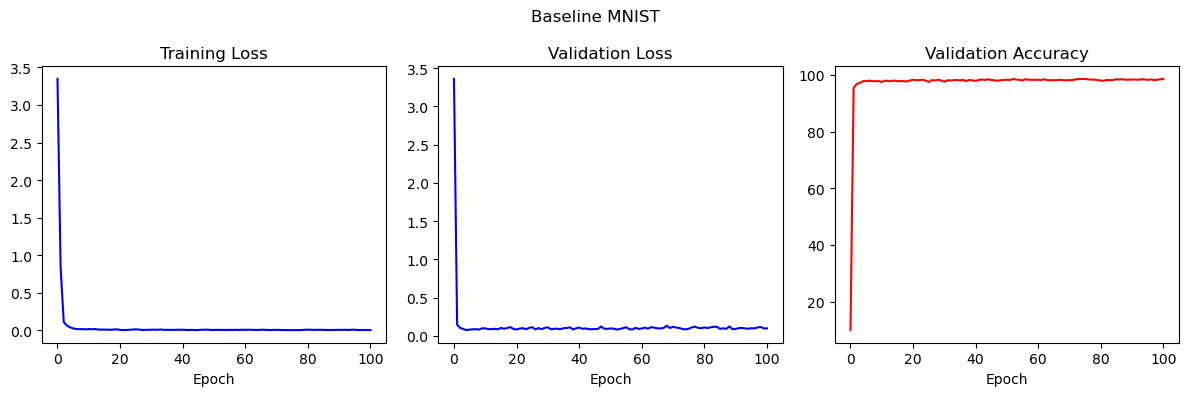

In [10]:
view_training_graphs(baseline_model_training_loss, baseline_model_validation_loss, baseline_model_validation_accuracy, 'Baseline MNIST')

In [11]:
# Function to perform SVD and return compressed weights
def compress_layer_weights(layer, D):
    U, S, V = torch.svd(layer.weight)
    compressed_U = U[:, :D]
    compressed_S = S[:D]
    compressed_V = V[:, :D]
    compressed_weights = torch.mm(compressed_U, torch.mm(torch.diag(compressed_S), compressed_V.t()))
    n_params = compressed_U.shape[0] * compressed_U.shape[1] + len(compressed_S) + compressed_V.shape[0] * compressed_V.shape[1]
    return compressed_weights, n_params, [compressed_U, torch.mm(torch.diag(compressed_S), compressed_V.t())]


# Create six versions of the model with different compression levels
D_values = [10, 20, 50, 100, 200, 784]  # Dfull for the last layer
compressed_models = {}
compressed_models_validation_accuracies = {} # D: acc
compressed_model_n_params = {}
baseline_model_n_parameters = sum(p.numel() for p in baseline_model.parameters())
compressed_model_20_layer_params = []
for D in D_values:
    
    compressed_model = copy.deepcopy(baseline_model)
    compressed_model_n_params_D = 0
    
    for layer in [compressed_model.fc1, compressed_model.fc2, compressed_model.fc3, compressed_model.fc4, compressed_model.fc5]:
        compressed_model_layer_weights, compressed_model_layer_n_params, compressed_model_layer_params= compress_layer_weights(layer, D)
        with torch.no_grad():
            layer.weight.copy_(compressed_model_layer_weights)
        compressed_model_n_params_D += compressed_model_layer_n_params
        if D == 20: # store the u, v for initialization in second question
            compressed_model_20_layer_params.append(compressed_model_layer_params)
    
    compressed_model_n_params[D] = compressed_model_n_params_D + compressed_model.out.weight.numel()
    compressed_models_validation_accuracies[D], _ = validate_model(compressed_model, criterion, valloader)
    compressed_models[D] = compressed_model.to(device)

In [12]:
acc, _ = validate_model(baseline_model, criterion, valloader)
acc

array(98.549995, dtype=float32)

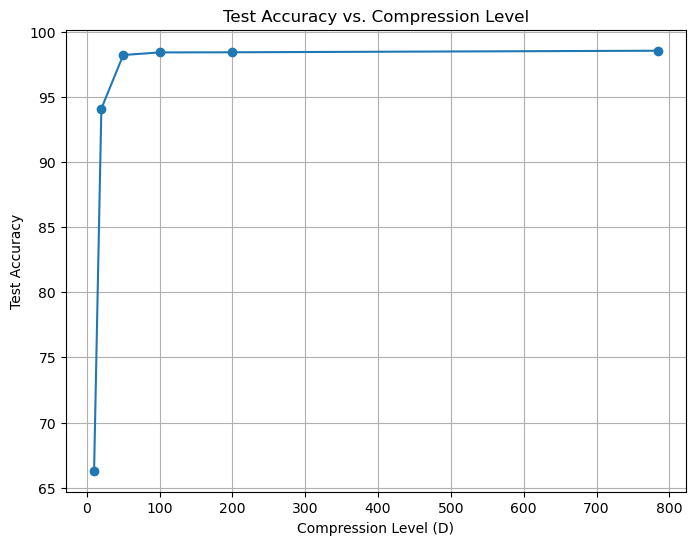

In [13]:
# Extract the keys and values from the test_accuracies dictionary
D_values = list(compressed_models_validation_accuracies.keys())
accuracy_values = list(compressed_models_validation_accuracies.values())

plt.figure(figsize=(8, 6)) 
plt.plot(D_values, accuracy_values, marker='o')
plt.xlabel('Compression Level (D)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Compression Level')

plt.grid()
plt.show()

In [14]:
# Define the header and format string
header = "Model           | Parameters"
format_string = "{:<15} | {:>10}"

print(header)
# Print the baseline model parameters
print(format_string.format("Baseline", baseline_model_n_parameters))
# Print the parameters for other models
for key, value in compressed_model_n_params.items():
    print(format_string.format(f"D:{key}", value))

Model           | Parameters
Baseline        |    5012490
D:10            |     110290
D:20            |     210340
D:50            |     510490
D:100           |    1010740
D:200           |    2011240
D:784           |    7854160


# Part 2

In [15]:
class FactorizedMNIST(nn.Module):
    def __init__(self, D):
        super(FactorizedMNIST, self).__init__()
        self.D = D
        self.fc1_V = nn.Parameter(torch.empty(28*28, D))
        self.fc1_U = nn.Parameter(torch.empty(D, 1024))
        self.fc2_V = nn.Parameter(torch.empty(1024, D))
        self.fc2_U = nn.Parameter(torch.empty(D, 1024))
        self.fc3_V = nn.Parameter(torch.empty(1024, D))
        self.fc3_U = nn.Parameter(torch.empty(D, 1024))
        self.fc4_V = nn.Parameter(torch.empty(1024, D))
        self.fc4_U = nn.Parameter(torch.empty(D, 1024))
        self.fc5_V = nn.Parameter(torch.empty(1024, D))
        self.fc5_U = nn.Parameter(torch.empty(D, 1024))
        self.out = nn.Linear(1024, 10)
        self.b = nn.Parameter(torch.empty(1024))
        self.relu = nn.ReLU()

        self.initialize_weights()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.relu(self.factorized_linear(x, self.fc1_U, self.fc1_V, self.b))
        x = self.relu(self.factorized_linear(x, self.fc2_U, self.fc2_V, self.b))
        x = self.relu(self.factorized_linear(x, self.fc3_U, self.fc3_V, self.b))
        x = self.relu(self.factorized_linear(x, self.fc4_U, self.fc4_V, self.b))
        x = self.relu(self.factorized_linear(x, self.fc5_U, self.fc5_V, self.b))
        return self.out(x)

    def factorized_linear(self, x, U, V, b):
        w = torch.mm(U, V)
        x = torch.mm(x, w.t()) 
        return x

    def initialize_weights(self):
        for i, (U, V) in enumerate(compressed_model_20_layer_params):
            if i == 0:
                self.fc1_U.data = U
                self.fc1_V.data = V
            elif i == 1:
                self.fc2_U.data = U
                self.fc2_V.data = V
            elif i == 2:
                self.fc3_U.data = U
                self.fc3_V.data = V
            elif i == 3:
                self.fc4_U.data = U
                self.fc4_V.data = V
            elif i == 4:
                self.fc5_U.data = U
                self.fc5_V.data = V
        self.out.load_state_dict(baseline_model.out.state_dict())

In [16]:
factorized_model = FactorizedMNIST(D = 20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(factorized_model.parameters(), lr = 1e-5)

In [17]:
acc, _ = validate_model(compressed_models[20], criterion, valloader)
acc

array(90.189995, dtype=float32)

In [18]:
acc, _ = validate_model(factorized_model, criterion, valloader)
acc


array(90.88, dtype=float32)

In [19]:
factorized_model_training_loss, factorized_model_validation_loss, factorized_model_validation_accuracy, factorized_model = \
        train_model(factorized_model, criterion, optimizer, trainloader, valloader, 100)

Training Loss: 0.0195 Validation Loss: 0.11527 Validation Accuracy: 97.79000: 100%|██████████| 100/100 [05:11<00:00,  3.12s/epoch]


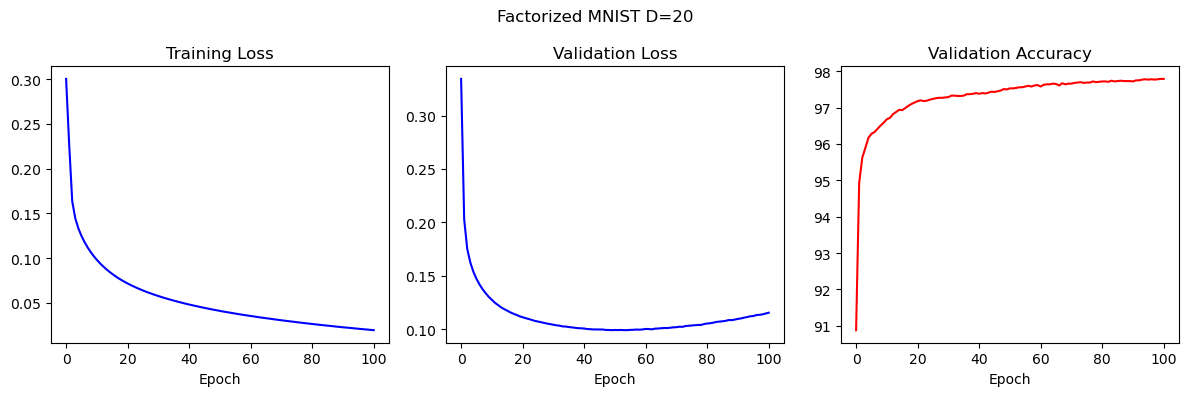

In [21]:
view_training_graphs(factorized_model_training_loss, factorized_model_validation_loss, factorized_model_validation_accuracy, 'Factorized MNIST D=20')

# Part 3

In [15]:
class MNIST20(nn.Module):
    def __init__(self):
        super(MNIST20, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.out = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.relu(self.compress(self.fc1.weight, x))
        x = self.relu(self.compress(self.fc2.weight, x))
        x = self.relu(self.compress(self.fc3.weight, x))
        x = self.relu(self.compress(self.fc4.weight, x))
        x = self.relu(self.compress(self.fc5.weight, x))
        return self.out(x)
    
    def compress(self, weight, x, D = 20):
        U, S, V = torch.svd(weight)
        compressed_U = U[:, :D]
        compressed_S = S[:D]
        compressed_V = V[:, :D]
        w = torch.mm(compressed_U, torch.mm(torch.diag(compressed_S), compressed_V.t()))
        x = torch.mm(x, w.t()) 
        return x
    

In [16]:
mnist20_model = MNIST20().to(device)
mnist20_model.load_state_dict(baseline_model.state_dict())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mnist20_model.parameters(), lr = 1e-5)

In [17]:
mnist20_model_training_loss, mnist20_model_validation_loss, mnist20_model_validation_accuracy, mnist20_model = \
        train_model(mnist20_model, criterion, optimizer, trainloader, valloader, 50)

Training Loss: 0.0239 Validation Loss: 0.09087 Validation Accuracy: 97.93999: 100%|██████████| 50/50 [28:43<00:00, 34.46s/epoch]


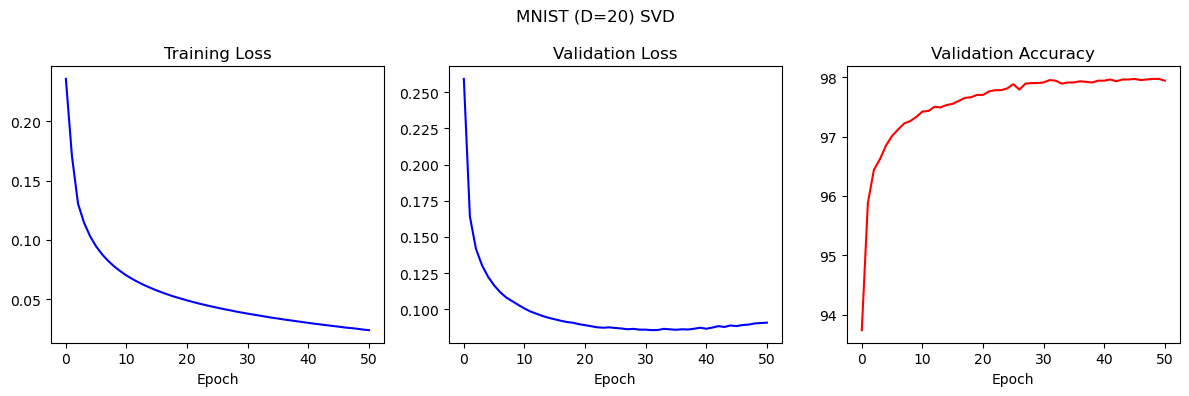

In [18]:
view_training_graphs(mnist20_model_training_loss, mnist20_model_validation_loss, mnist20_model_validation_accuracy, 'MNIST (D=20) SVD')